In [9]:
import joblib

mlp = joblib.load("mlp_model.pkl")

In [10]:
from project import load_data


X_train, X_test, y_train, y_test = load_data()

alcohol
CL5    757
CL6    503
CL4    284
CL3    197
CL2     68
CL1     34
CL0     33
Name: count, dtype: int64
amphet
CL0    973
CL2    240
CL1    230
CL3    196
CL6    101
CL4     75
CL5     61
Name: count, dtype: int64
amyl
CL0    1298
CL2     236
CL1     210
CL3      91
CL4      24
CL5      14
CL6       3
Name: count, dtype: int64
benzos
CL0    999
CL3    234
CL2    229
CL4    119
CL1    116
CL6     95
CL5     84
Name: count, dtype: int64
caff
CL6    1379
CL5     271
CL4     106
CL3      59
CL0      27
CL2      24
CL1      10
Name: count, dtype: int64
cannabis
CL6    458
CL0    412
CL2    266
CL3    210
CL1    207
CL5    185
CL4    138
Name: count, dtype: int64
choc
CL6    805
CL5    679
CL4    295
CL3     53
CL0     32
CL2     10
CL1      2
Name: count, dtype: int64
coke
CL0    1035
CL2     267
CL3     257
CL1     160
CL4      98
CL5      40
CL6      19
Name: count, dtype: int64
crack
CL0    1621
CL2     109
CL1      67
CL3      59
CL5       9
CL4       9
CL6       2
Name: count, d

In [42]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=[0, 1], discretize_continuous=False)
lime_values = [dict(sorted(lime_explainer.explain_instance(x, mlp.predict_proba, num_features=12).as_list(), key=lambda x: x[0])) for x in X_test.values]


In [31]:
import shap

shap_explainer = shap.KernelExplainer(mlp.predict_proba, X_test)
shap_values = shap_explainer.shap_values(X_test)


Using 376 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 376/376 [12:00<00:00,  1.92s/it]


In [36]:
shap_values_positive = shap_values[:, :, 1]

In [13]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, mlp_model):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(20, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 2)  # Adjust output size based on your problem

        # Copy weights from the trained MLPClassifier
        self.hidden1.weight.data = torch.tensor(mlp_model.coefs_[0].T, dtype=torch.float32)
        self.hidden1.bias.data = torch.tensor(mlp_model.intercepts_[0], dtype=torch.float32)
        self.hidden2.weight.data = torch.tensor(mlp_model.coefs_[1].T, dtype=torch.float32)
        self.hidden2.bias.data = torch.tensor(mlp_model.intercepts_[1], dtype=torch.float32)
        self.output.weight.data = torch.tensor(mlp_model.coefs_[2].T, dtype=torch.float32)
        self.output.bias.data = torch.tensor(mlp_model.intercepts_[2], dtype=torch.float32)

    def forward(self, x):
        x = torch.sigmoid(self.hidden1(x))
        x = torch.sigmoid(self.hidden2(x))
        x = self.output(x)
        return x

# Create a PyTorch model from the scikit-learn model
torch_model = MLP(mlp)

In [14]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [15]:
from captum.attr import LRP
import numpy as np

lrp = LRP(torch_model)

attributions = lrp.attribute(X_test_tensor)
attributions = attributions.detach().cpu().numpy()


/Users/connormacdonald/miniconda3/envs/ai-base/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [46]:
lime_values_featureless = [list(val.values()) for val in lime_values]
lime_values_featureless[0]

[-0.1331210253307985,
 0.0037415050247531557,
 -0.1130803411799598,
 -0.07999726519867913,
 -0.07678774515645626,
 -0.029723712604049345,
 0.008000692905538759,
 -0.034977922136757336,
 -0.018909315479704168,
 -0.04038282066333372,
 0.12604576504465534,
 0.10050066989441835]

In [100]:
import importlib
import evaluation
importlib.reload(evaluation)

lime_evaluations, lime_fpr, lime_tpr, lime_roc_auc = evaluation.run_evaluations(lime_values_featureless, y_test.values.ravel())

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}


In [101]:
shap_evaluations, shap_fpr, shap_tpr, shap_roc_auc = evaluation.run_evaluations(shap_values_positive, y_test.values.ravel())

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 100}


In [107]:
lrp_evaluations, lrp_fpr, lrp_tpr, lrp_roc_auc = evaluation.run_evaluations(attributions, y_test.values.ravel())

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}


In [103]:
lime_evaluations

,k,Silhouette Kmeans,Silhouette Spectral,DBI Kmeans,DBI Spectral
0,2,0.950187,-0.157853,0.033854,1.146439
1,3,0.277064,-0.223974,0.986727,1.098384
2,4,0.224888,-0.258530,1.081794,1.350200
3,5,0.214899,-0.280718,1.118224,1.147104
4,6,0.172420,-0.241673,1.364027,1.514735
5,7,0.169518,-0.302061,1.316577,1.119707
6,8,0.154471,-0.342392,1.464572,1.578319


In [104]:
shap_evaluations

,k,Silhouette Kmeans,Silhouette Spectral,DBI Kmeans,DBI Spectral
0,2,0.259481,-0.001182,1.446427,0.962350
1,3,0.313431,-0.246145,1.166531,0.926404
2,4,0.311744,-0.257768,1.293091,0.854804
3,5,0.249206,-0.264847,1.587472,0.862645
4,6,0.234480,-0.281832,1.692605,0.857820
5,7,0.202613,-0.282168,1.694806,0.859638
6,8,0.169010,-0.282224,2.000143,0.987551


In [105]:
lrp_evaluations

,k,Silhouette Kmeans,Silhouette Spectral,DBI Kmeans,DBI Spectral
0,2,0.966807,-0.763099,0.206783,1.514677
1,3,0.926113,-0.760846,0.362928,1.514157
2,4,0.892761,-0.758601,0.461210,1.513557
3,5,0.877126,-0.756098,0.378639,1.530598
4,6,0.855432,-0.753728,0.400106,1.527116
5,7,0.746901,-0.751536,0.446967,1.511585
6,8,0.743006,-0.749144,0.467280,1.510902


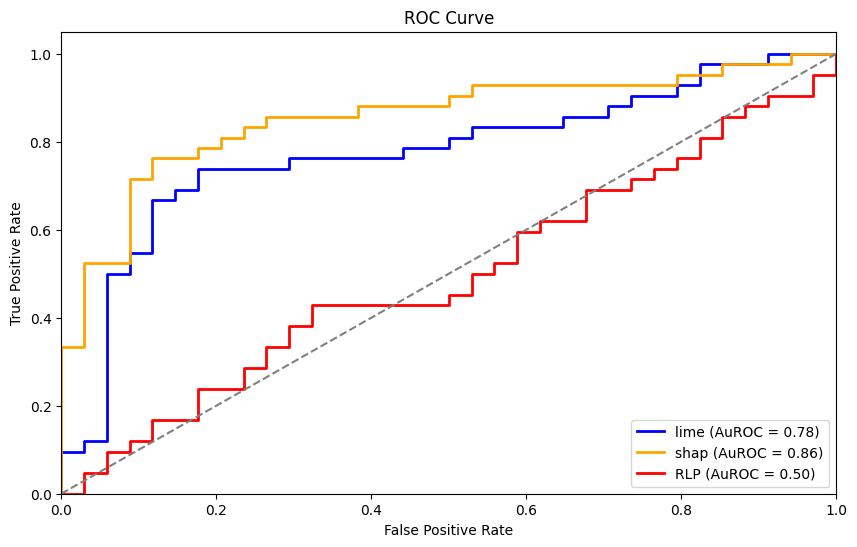

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lime_fpr, lime_tpr, color='blue', lw=2, label=f'lime (AuROC = {lime_roc_auc:.2f})')
plt.plot(shap_fpr, shap_tpr, color='orange', lw=2, label=f'shap (AuROC = {shap_roc_auc:.2f})')
plt.plot(lrp_fpr, lrp_tpr, color='red', lw=2, label=f'RLP (AuROC = {lrp_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()